In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import statsmodels
import os
import cv2
from  PIL.Image import Image
from sklearn.model_selection import train_test_split 
import tensorflow as tf
import shutil
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [202]:
data_dir = "datasets"

In [4]:
#####    creating a dataframe with name,locations and labels  of all images in dataset inorder to split it into train and test

data=pd.DataFrame(columns=["image_name","location","label"])

df1=pd.DataFrame()
df2=pd.DataFrame()
temp=pd.DataFrame(columns=["name","location","labels"])
for index,(root,folder,files) in enumerate(os.walk(r"datasets/")):
    if index!=0:
        temp["name"]=files
        temp["location"]=root
        temp["labels"]=root.split("/")[-1]
        df1=pd.concat([df1,temp])


In [6]:
df1.head(5)

,name,location,labels
0,0.jpg,datasets/Cat,Cat
1,1.jpg,datasets/Cat,Cat
2,10.jpg,datasets/Cat,Cat
3,100.jpg,datasets/Cat,Cat
4,1000.jpg,datasets/Cat,Cat


In [204]:
#  split  the dataframe with dataset info into train and test  
train,test=train_test_split(df1,test_size=0.3,stratify=df1["labels"])


In [206]:
# convert the splitted train and test dataset info df into csv

train.to_csv("data_files/train.csv")
test.to_csv("data_files/test.csv")

####   creating train and test folders for dog and cat respecively inorder to facilitate further process

In [207]:
#  creating folder with training images of dogs

for i ,j in zip(train[train["labels"]=="Dog"]["location"].values,train[train["labels"]=="Dog"]["name"].values):
    path=os.path.join(i,j)
    shutil.copy(path,r"data_files\train\dog")
    

In [208]:
#  creating folder with training images of cats

for i ,j in zip(train[train["labels"]=="Cat"]["location"].values,train[train["labels"]=="Cat"]["name"].values):
    path=os.path.join(i,j)
    shutil.copy(path,r"data_files\train\cat")

In [209]:
#  creating folder with testing images of dog

for i ,j in zip(test[test["labels"]=="Dog"]["location"].values,test[test["labels"]=="Dog"]["name"].values):
    path=os.path.join(i,j)
    shutil.copy(path,r"data_files\test\dog")

In [210]:
#  creating folder with testing images of cat

for i ,j in zip(test[test["labels"]=="Cat"]["location"].values,test[test["labels"]=="Cat"]["name"].values):
    path=os.path.join(i,j)
    shutil.copy(path,r"data_files\test\cat")


#####   Now we have our cat and dog images splitted into train and test and placed in respective folders under data_files directory
#####  Now let us use image generator and flow from directory methods to load the required data

###  Building CNN with Augmentation

In [240]:
data_generator_wa=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=90,
    zoom_range=(0.95, 0.95), 
    fill_mode='nearest',
    validation_split=0.3

)


In [241]:
training_directory="data_files/train"
testing_directory="data_files/test"
batch_size=32
img_height = 224
img_width = 224
train_data_wa=data_generator_wa.flow_from_directory(
    training_directory,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="rgb",
    subset="training",
    seed=1
    
)

test_data_wa=data_generator_wa.flow_from_directory(
    testing_directory,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="rgb",
    subset="validation",
    seed=1
    
)

Found 12250 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.


Label 0.0


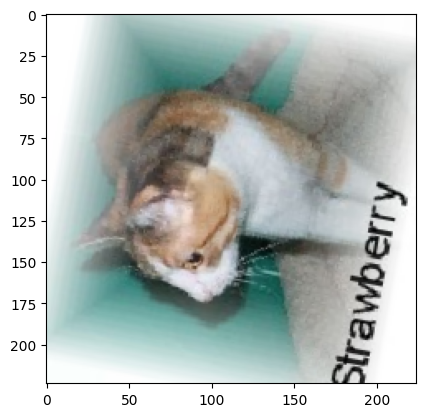

In [242]:
# viewing one image from train data and check its label
for i in train_data_wa:
    plt.imshow(i[0][1,:])
    print("Label",i[1][1])
    break

# Cat is labelled as 0 and Dog is labelled as 1

In [243]:
#  CNN model with Augmentation

def model_build():
    return tf.keras.models.Sequential([
    ###  Convolute

    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),

    ###  ANN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64,activation="relu"),
    tf.keras.layers.Dense(units=2,activation="softmax")
        
    ])

def model_compile(model):
     model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

def model_train(model,train_gen,epoch,steps_per_ep,validation_gen,validation_steps):
     return model.fit(train_gen,epochs=epoch,steps_per_epoch=steps_per_ep,validation_data=validation_gen,validation_steps=validation_steps  )

In [244]:
train_steps_per_epoch_wa=np.floor(len(train_data_wa.classes)/train_data_wa.batch_size)  # steps taken per epoch-> len(train_dataset)/batch_size
test_steps_per_epoch_wa=np.floor(len(test_data_wa.classes)/test_data_wa.batch_size)
model_wa=model_build()
model_compile(model_wa)
history=model_train(model_wa,train_gen=train_data_wa,epoch=10,steps_per_ep=train_steps_per_epoch_wa,validation_gen=test_data_wa,validation_steps=test_steps_per_epoch_wa)


Epoch 1/10
160/382 [===========>..................] - ETA: 7:01 - loss: 0.8018 - accuracy: 0.5579

c:\Users\Vijay\anaconda3\envs\happy_monk\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


382/382 [==============================] - 784s 2s/step - loss: 0.7221 - accuracy: 0.5823 - val_loss: 0.6641 - val_accuracy: 0.5978
Epoch 2/10
382/382 [==============================] - 770s 2s/step - loss: 0.6346 - accuracy: 0.6411 - val_loss: 0.6019 - val_accuracy: 0.6732
Epoch 3/10
382/382 [==============================] - 4020s 11s/step - loss: 0.5917 - accuracy: 0.6858 - val_loss: 0.5589 - val_accuracy: 0.7125
Epoch 4/10
382/382 [==============================] - 743s 2s/step - loss: 0.5659 - accuracy: 0.7108 - val_loss: 0.5376 - val_accuracy: 0.7415
Epoch 5/10
382/382 [==============================] - 758s 2s/step - loss: 0.5466 - accuracy: 0.7243 - val_loss: 0.5535 - val_accuracy: 0.7174
Epoch 6/10
382/382 [==============================] - 721s 2s/step - loss: 0.5297 - accuracy: 0.7369 - val_loss: 0.5050 - val_accuracy: 0.7598
Epoch 7/10
382/382 [==============================] - 781s 2s/step - loss: 0.5162 - accuracy: 0.7439 - val_loss: 0.5213 - val_accuracy: 0.7518
Epoch 8/

In [246]:
train_loss_wa=history.history["loss"]
train_acc_wa=history.history["accuracy"]
test_loss_wa=history.history["val_loss"]
test_acc_wa=history.history["val_accuracy"]


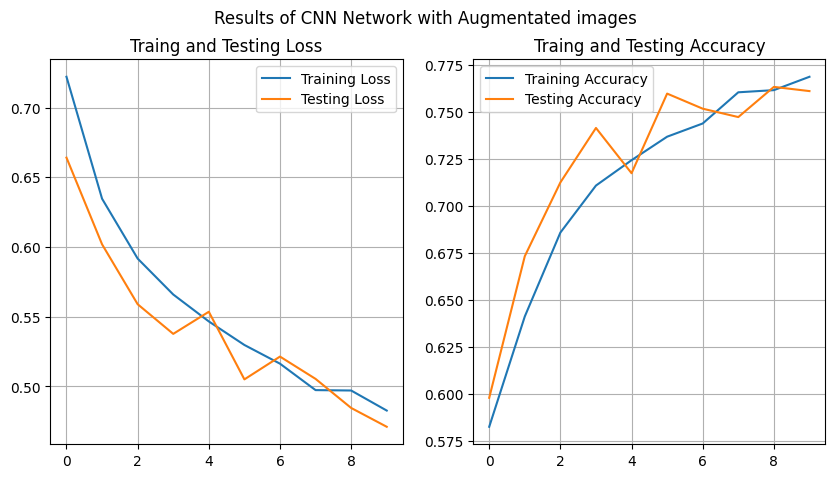

In [344]:
# 
fig,axis=plt.subplots(1,2,figsize=(10,5))
sns.lineplot(train_loss_wa,ax=axis[0],label="Training Loss")
sns.lineplot(test_loss_wa,ax=axis[0],label="Testing Loss")
axis[0].set_title("Traing and Testing Loss")
axis[0].legend()
sns.lineplot(train_acc_wa,ax=axis[1],label="Training Accuracy")
axis[0].grid(True)
axis[1].set_title("Traing and Testing Accuracy")
sns.lineplot(test_acc_wa,ax=axis[1],label="Testing Accuracy")
axis[1].legend()
plt.suptitle("Results of CNN Network with Augmentated images")
axis[1].grid(True)
plt.show()

In [263]:
#  saving the model

model_wa.save("model_objects\cnn_model_wa.h5")

In [330]:
###  Saving the history details of CNN with Augmentation
with open("model_objects/cnn_model_history_wa.json","wt") as s:
    json.dump(history.history,s)

